In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df= pd.read_csv("/content/heart_failure_clinical_records_dataset (1).csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75,0,582,0,20,1,265000,1.9,130,1,0,4,1
1,55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
2,65,0,146,0,20,0,162000,1.3,129,1,1,7,1
3,50,1,111,0,20,0,210000,1.9,137,1,0,7,1
4,65,1,160,1,20,0,327000,2.7,116,0,0,8,1


In [ ]:
X = df.drop(["DEATH_EVENT"],axis=1,inplace=False)
y = df[["DEATH_EVENT"]]
print(y)

     DEATH_EVENT
0              1
1              1
2              1
3              1
4              1
..           ...
294            0
295            0
296            0
297            0
298            0

[299 rows x 1 columns]


## Information Gain

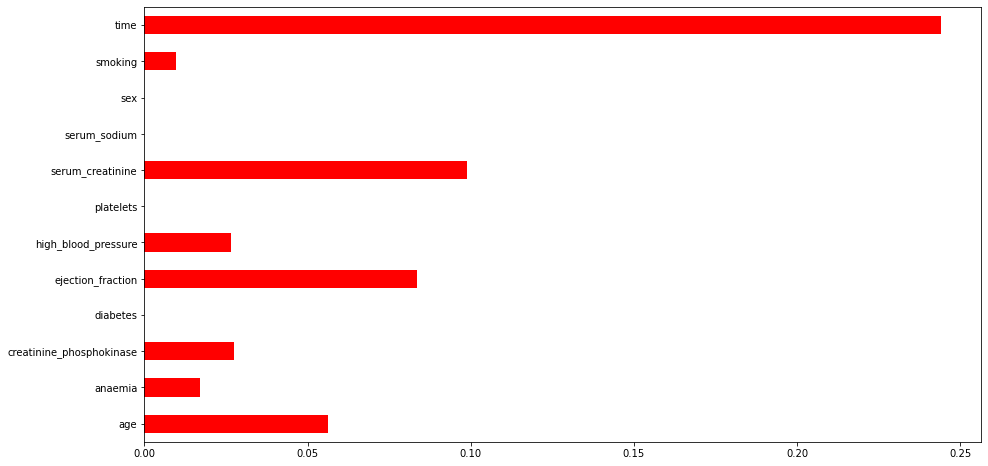

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline

importances = mutual_info_classif(X,y)
feat_features = pd.Series(importances,X.columns)
feat_features.plot(kind = 'barh', color = 'red',figsize = (15,8))
plt.show()

# Oversampling with GAN

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from keras.optimizers import adam_v2
from tensorflow.keras.utils import to_categorical
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.stats
import datetime as dt
import pydot
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
df_minority_data=df.loc[df['DEATH_EVENT'] == 1]

In [ ]:
#Subsetting input features without target variable
df_minority_data_withouttv=df_minority_data.loc[:, df_minority_data.columns != 'DEATH_EVENT']
numerical_df = df_minority_data_withouttv.select_dtypes("number")
scaling = MinMaxScaler()
numerical_df_rescaled = scaling.fit_transform(numerical_df)

In [ ]:
def define_generator (numerical):
  #Inputting noise  from latent space
    noise = Input(shape = (100,))
    hidden_1 = Dense(8, kernel_initializer = "he_uniform")(noise)
    hidden_1 = LeakyReLU(0.2)(hidden_1)
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)
    hidden_2 = Dense(16, kernel_initializer = "he_uniform")(hidden_1)
    hidden_2 = LeakyReLU(0.2)(hidden_2)
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)

    #Branch 1 for generating location data

    branch_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_1 = LeakyReLU(0.2)(branch_1)
    branch_1 = BatchNormalization(momentum = 0.8)(branch_1)
    branch_1 = Dense(64, kernel_initializer = "he_uniform")(branch_1)
    branch_1 = LeakyReLU(0.2)(branch_1)
    branch_1 = BatchNormalization(momentum=0.8)(branch_1)

    branch_1_output = Dense(numerical, activation = "sigmoid")(branch_1)

    #Combined output
    combined_output = concatenate([branch_1_output])

    #Return model

    return Model(inputs = noise, outputs = combined_output)


generator = define_generator(numerical_df_rescaled.shape[1])
generator.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_22 (Dense)            (None, 8)                 808       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 8)                 0         
                                                                 
 batch_normalization_8 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_23 (Dense)            (None, 16)                144       
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 16)                0         
                                                           

In [ ]:
from tensorflow.keras.optimizers import Adam
def define_discriminator(inputs_n):
    #Input from generator
    d_input = Input(shape = (inputs_n,))
    d = Dense(128, kernel_initializer="he_uniform")(d_input)
    d = LeakyReLU(0.2)(d)
    d = Dense(64, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(32, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(16, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(8, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)

    #Output Layer
    d_output = Dense(1, activation = "sigmoid")(d)

    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5), metrics = ["accuracy"])
    return model


inputs_n =numerical_df_rescaled.shape[1]
discriminator = define_discriminator(inputs_n)
discriminator.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_27 (Dense)            (None, 128)               1664      
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 32)                0   

In [ ]:
def define_complete_gan(generator, discriminator):
    discriminator.trainable = False
    gan_output = discriminator(generator.output)

    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)

    #Model Compilation
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0002, beta_1=0.5))
    return model

completegan = define_complete_gan(generator, discriminator)

Epoch: 200 [Discriminator loss: 0.318631] [Generator loss: 1.897194]
Epoch: 400 [Discriminator loss: 0.332521] [Generator loss: 1.901046]
Epoch: 600 [Discriminator loss: 0.387173] [Generator loss: 1.607435]
Epoch: 800 [Discriminator loss: 0.464538] [Generator loss: 1.279279]
Epoch: 1000 [Discriminator loss: 0.525126] [Generator loss: 1.152646]
Epoch: 1200 [Discriminator loss: 0.615033] [Generator loss: 1.083800]


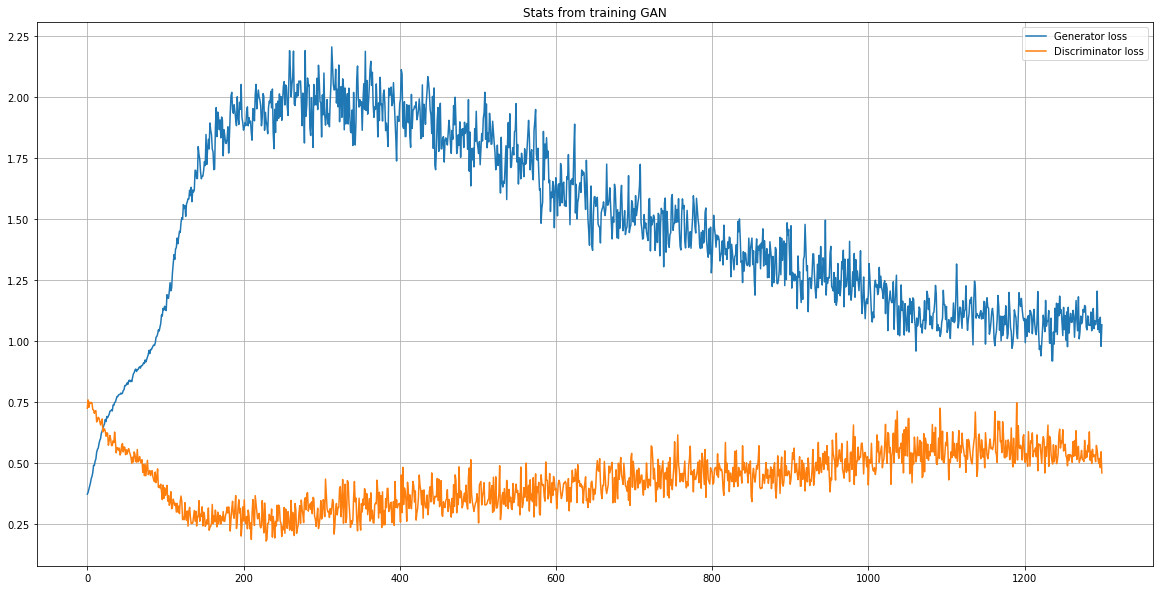

In [ ]:
def gan_train(gan, generator, discriminator, numerical, latent_dim, n_epochs, n_batch, n_eval):
    #Upddte Discriminator with half batch size
    half_batch = int(n_batch / 2)
    discriminator_loss = []
    generator_loss = []
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    fake = np.zeros((half_batch, 1))

    #training
    for i in range(n_epochs):
        #select random batch from real categorical and numerical data
        idx = np.random.randint(0, numerical.shape[0], half_batch)
        numerical_real = numerical_df_rescaled[idx]

        #concatenate categorical and numerical data for the discriminator
        real_data = np.concatenate([numerical_real], axis = 1)

        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #generate noise for generator input and train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))

    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.grid()
    plt.legend()

latent_dim = 100
gan_train(completegan, generator, discriminator, numerical_df_rescaled, latent_dim, n_epochs = 1300, n_batch = 63, n_eval = 200)

In [ ]:
noise = np.random.normal(0, 1, (96, 100))
generated_mixed_data = generator.predict(noise)
columns=list(numerical_df.columns)
mixed_gen_df = pd.DataFrame(data = generated_mixed_data, columns = columns)
mixed_gen_df.iloc[:,:-3] = np.round(mixed_gen_df.iloc[:,:-3])
#mixed_gen_df.iloc[:,-2:] = scaling.inverse_transform(mixed_gen_df.iloc[:,-2:])


In [ ]:
#Original Data
original_df = pd.concat([numerical_df], axis = 1)
def normal_distribution(org, noise):
    org_x = np.linspace(org.min(), org.max(), len(org))
    noise_x = np.linspace(noise.min(), noise.max(), len(noise))
    org_y = scipy.stats.norm.pdf(org_x, org.mean(), org.std())
    noise_y = scipy.stats.norm.pdf(noise_x, noise.mean(), noise.std())
    n, bins, patches = plt.hist([org, noise], density = True, alpha = 0.5, color = ["green", "red"])
    xmin, xmax = plt.xlim()
    plt.plot(org_x, org_y, color = "green", label = "Original data", alpha = 0.5)
    plt.plot(noise_x, noise_y, color = "red", label = "Generated data", alpha = 0.5)
    title = f"Original data mean {np.round(org.mean(), 4)}, Original data std {np.round(org.std(), 4)}, Original data var {np.round(org.var(), 4)}\nGenerated data mean {np.round(noise.mean(), 4)}, Generated data {np.round(noise.std(), 4)}, Generated data var {np.round(noise.var(), 2)}"
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

age Comparison between Original Data and Generated Data


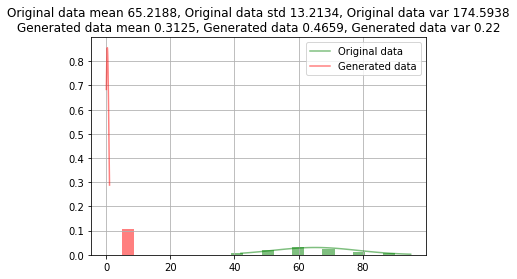

anaemia Comparison between Original Data and Generated Data


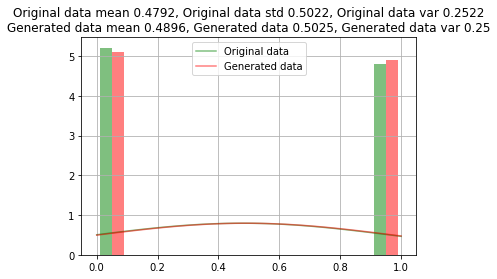

creatinine_phosphokinase Comparison between Original Data and Generated Data


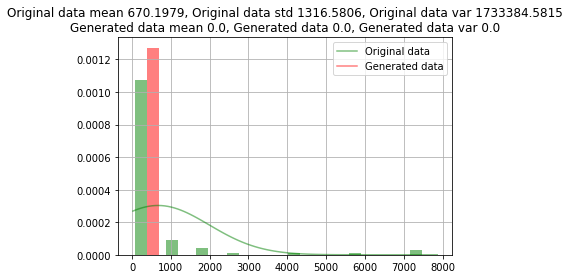

diabetes Comparison between Original Data and Generated Data


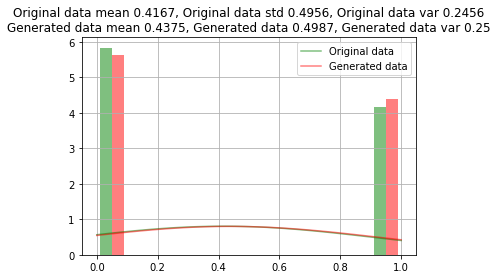

ejection_fraction Comparison between Original Data and Generated Data


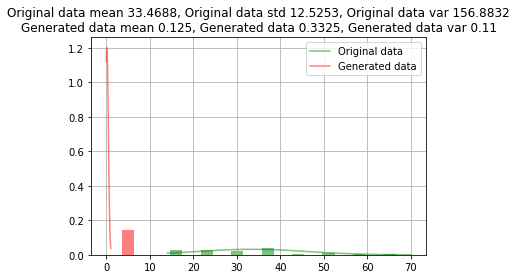

high_blood_pressure Comparison between Original Data and Generated Data


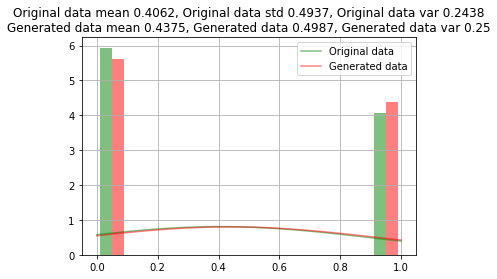

platelets Comparison between Original Data and Generated Data


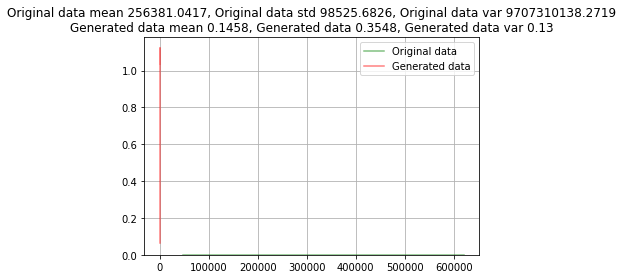

serum_creatinine Comparison between Original Data and Generated Data


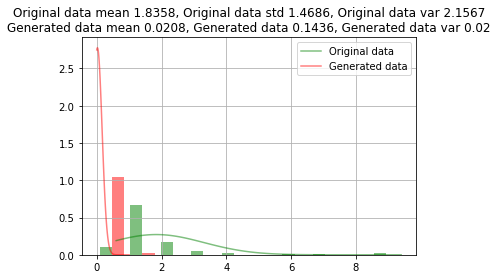

serum_sodium Comparison between Original Data and Generated Data


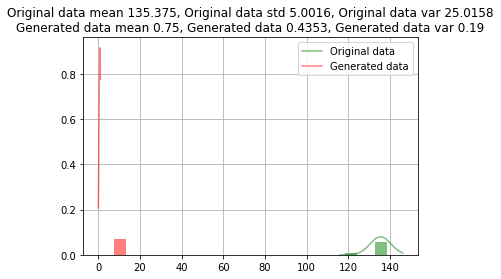

sex Comparison between Original Data and Generated Data


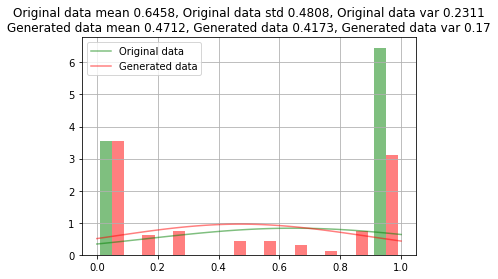

smoking Comparison between Original Data and Generated Data


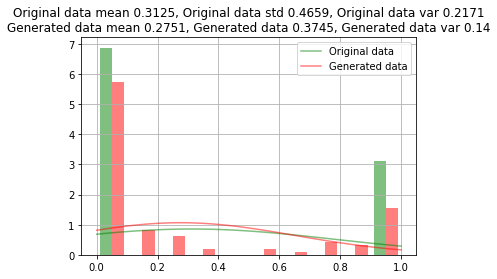

time Comparison between Original Data and Generated Data


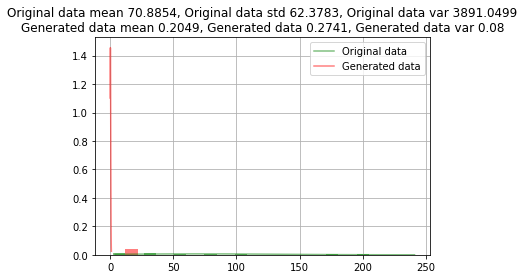

In [ ]:
Numeric_columns=numerical_df.columns

for column in numerical_df.columns:
    print(column, "Comparison between Original Data and Generated Data")
    normal_distribution(original_df[column], mixed_gen_df[column])

In [ ]:
from sklearn.metrics import recall_score as rs
from sklearn.metrics import precision_score as ps
from sklearn.metrics import f1_score as fs
from sklearn.metrics import balanced_accuracy_score as bas
from sklearn.metrics import confusion_matrix as cm
import numpy as np
import pandas as pd
import datetime as dt
import sklearn
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score as rs
from sklearn.metrics import precision_score as ps
from sklearn.metrics import f1_score as fs
from sklearn.metrics import log_loss


rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
criterion='gini', max_depth=2, max_features='auto',
max_leaf_nodes=None, max_samples=None,
min_impurity_decrease=0.0,
min_samples_leaf=2, min_samples_split=2,
min_weight_fraction_leaf=0.0, n_estimators=100,
n_jobs=None, oob_score=False, random_state=None,  verbose=0, warm_start=False)
classifier = rf

mixed_gen_df['DEATH_EVENT'] = 1
#Seperate TV in Generated Data
X1 = mixed_gen_df.loc[:, mixed_gen_df.columns != 'DEATH_EVENT']
Y1 = mixed_gen_df['DEATH_EVENT']
print(mixed_gen_df)

#Seperate TV in Original Data
X = df.loc[:, df.columns !=  'DEATH_EVENT']
Y = df['DEATH_EVENT']

# #Splitting Original Data
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

# # #Appending Generated Data to X_train
# # X_train1=X_train.append(X1, sort=False)
# # Y_train1=Y_train.append(Y1)
# # classifier.fit(X_train1,np.array(Y_train1).reshape(Y_train1.shape[0],1))
# # pred = np.array(classifier.predict(X_test))

# # recall = rs(Y_test,pred)
# # precision = ps(Y_test,pred)
# # r1 = fs(Y_test,pred)
# # ma = classifier.score(X_test,Y_test)
# # print('*** Evaluation metrics for test dataset ***\n')
# # print('Recall Score: ',recall)
# # print('Precision Score: ',precision)
# # print('F1 Score: ',f1_score)
# # print('Accuracy: ',ma)

    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0   0.0      0.0                       0.0       0.0                1.0   
1   0.0      0.0                       0.0       0.0                0.0   
2   0.0      0.0                       0.0       1.0                0.0   
3   0.0      1.0                       0.0       1.0                1.0   
4   1.0      0.0                       0.0       1.0                0.0   
..  ...      ...                       ...       ...                ...   
91  0.0      0.0                       0.0       0.0                0.0   
92  1.0      1.0                       0.0       0.0                0.0   
93  1.0      0.0                       0.0       0.0                0.0   
94  0.0      0.0                       0.0       0.0                0.0   
95  0.0      1.0                       0.0       1.0                0.0   

    high_blood_pressure  platelets  serum_creatinine  serum_sodium       sex  \
0                  

### Original Data Accuracy

In [ ]:
from sklearn.metrics import classification_report
#Splitting Original Data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
classifier.fit(X_train,Y_train)
y_pred = classifier.predict(X_test)
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        37
           1       1.00      0.43      0.61        23

    accuracy                           0.78        60
   macro avg       0.87      0.72      0.73        60
weighted avg       0.84      0.78      0.76        60



##Add Gan Data

In [ ]:
X_gan_added=X.append(X1, sort=False)
Y_gan_added=Y.append(Y1)

## Splitting Gan Data

In [ ]:
#Splitting mixed Data
X_gan_train, X_gan_test, Y_gan_train, Y_gan_test = train_test_split(X_gan_added,Y_gan_added,test_size=0.2,random_state=0)
classifier.fit(X_gan_train,Y_gan_train)
y_gan_pred = classifier.predict(X_gan_test)
print(classification_report(Y_gan_test,y_gan_pred))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85        39
           1       0.97      0.70      0.81        40

    accuracy                           0.84        79
   macro avg       0.86      0.84      0.83        79
weighted avg       0.86      0.84      0.83        79

